In [1]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import argparse

import cv2

import os
from sklearn.utils import shuffle
from tqdm import tqdm

import numpy as np


In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)



train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset',
        target_size=(370, 370),
        batch_size=924,
        shuffle=False
        )



Found 922 images belonging to 2 classes.


In [4]:
X_train, y_train = next(train_generator)
print(len(X_train))
len(y_train)

922


922

(370, 370, 3)


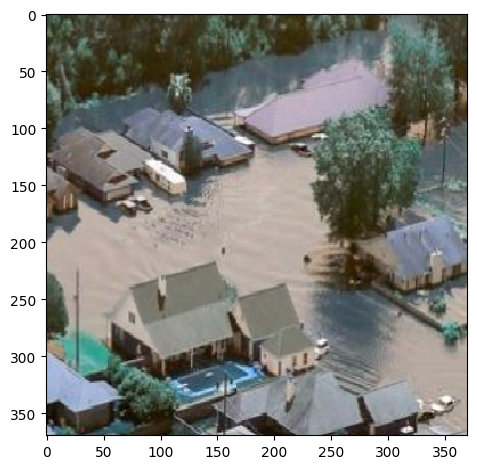

In [5]:

resizedimgs=X_train
label_names=train_generator.labels
resizedimgs, label_names = shuffle(resizedimgs, label_names)
from skimage import io

io.imshow(resizedimgs[0])
# io.imshow(resizedimgs[1])
# io.imshow(resizedimgs[2])
# io.imshow(resizedimgs[3])
# io.imshow(resizedimgs[4])
# io.imshow(resizedimgs[5])
# io.imshow(resizedimgs[6])
# io.imshow(resizedimgs[7])
label_names[0:10]
print(resizedimgs[2].shape)


In [6]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [7]:

 def to_gray(color_img):
    image8bit = cv2.normalize(color_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    gray = cv2.cvtColor(image8bit, cv2.COLOR_BGR2GRAY)
    return gray

In [8]:
def gen_sift_features(gray_img):
  
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [9]:
def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

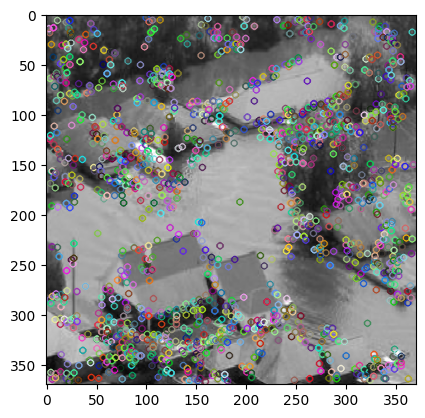

In [10]:
kp,d=gen_sift_features(to_gray(resizedimgs[0]))
show_sift_features(to_gray(resizedimgs[0]),resizedimgs[0],kp)

In [11]:
def create_features(img):
    # flatten three channel color image
    
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = to_gray(img)
    # get features from greyscale image
    kp,desc =gen_sift_features(grey_image)
    # combine color and hog features into a single array
    flat_features = np.hstack((desc))
    return flat_features
  
create_features(resizedimgs[0])

array([48., 17.,  4., ...,  0.,  0.,  0.], dtype=float32)

In [12]:

def create_feature_matrix(imgs):
    features_list = []
    minf=-1000000000
    for img_id in imgs:
        # load image 526336
        
        # get features for image
        image_features = create_features(img_id)
        if len( image_features)<250000:
          image_features=np.concatenate((image_features,np.zeros(250000-len( image_features))))
        else:
            image_features=image_features[0:250000]
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix ,minf

# run create_feature_matrix on our dataframe of images
feature_matrix,minf = create_feature_matrix(resizedimgs)
print(minf)

print(feature_matrix.shape)


-1000000000
(922, 250000)


In [13]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [14]:
# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

PCA matrix shape is:  (922, 250000)


In [15]:
X = pd.DataFrame(bees_pca)
y = pd.Series(label_names)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                   )

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    370
1    367
dtype: int64

In [16]:
# define support vector classifier
svm = SVC()

# fit model
svm.fit(X_train, y_train)

SVC()

In [17]:
from sklearn.metrics import classification_report
print(len(X_test))
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Model accuracy is: ', accuracy)
print(classification_report(y_test,y_pred))


185
Model accuracy is:  0.6864864864864865
              precision    recall  f1-score   support

           0       0.63      0.89      0.74        91
           1       0.82      0.49      0.61        94

    accuracy                           0.69       185
   macro avg       0.72      0.69      0.67       185
weighted avg       0.73      0.69      0.67       185

